In [13]:
#### this is to run FCN using emotion dataset (STEP)

from tsai.all import *
import sklearn.metrics as skm
from utils import loader

my_setup()

os              : Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.31
python          : 3.10.9
tsai            : 0.3.6
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.1+cu116
device          : 1 gpu (['NVIDIA GeForce GTX 1650 Ti'])
cpu cores       : 6
threads per cpu : 2
RAM             : 12.35 GB
GPU memory      : [4.0] GB


In [14]:
#### Adding STEP dataset###############

#base_path = os.path.dirname(os.path.realpath(__file__))
base_path = ''
ftype = ''   ### to change for differing subparts of step dataset
coords = 3
joints = 16
cycles = 1
test_size = 0.1
data, labels,\
    data_train, labels_train,\
    data_test, labels_test = loader.load_data(base_path, ftype, coords, joints,
                                              cycles=cycles, test_size=test_size)
data_train_new = np.swapaxes(data_train,1,2)
data_test_new = np.swapaxes(data_test,1,2)




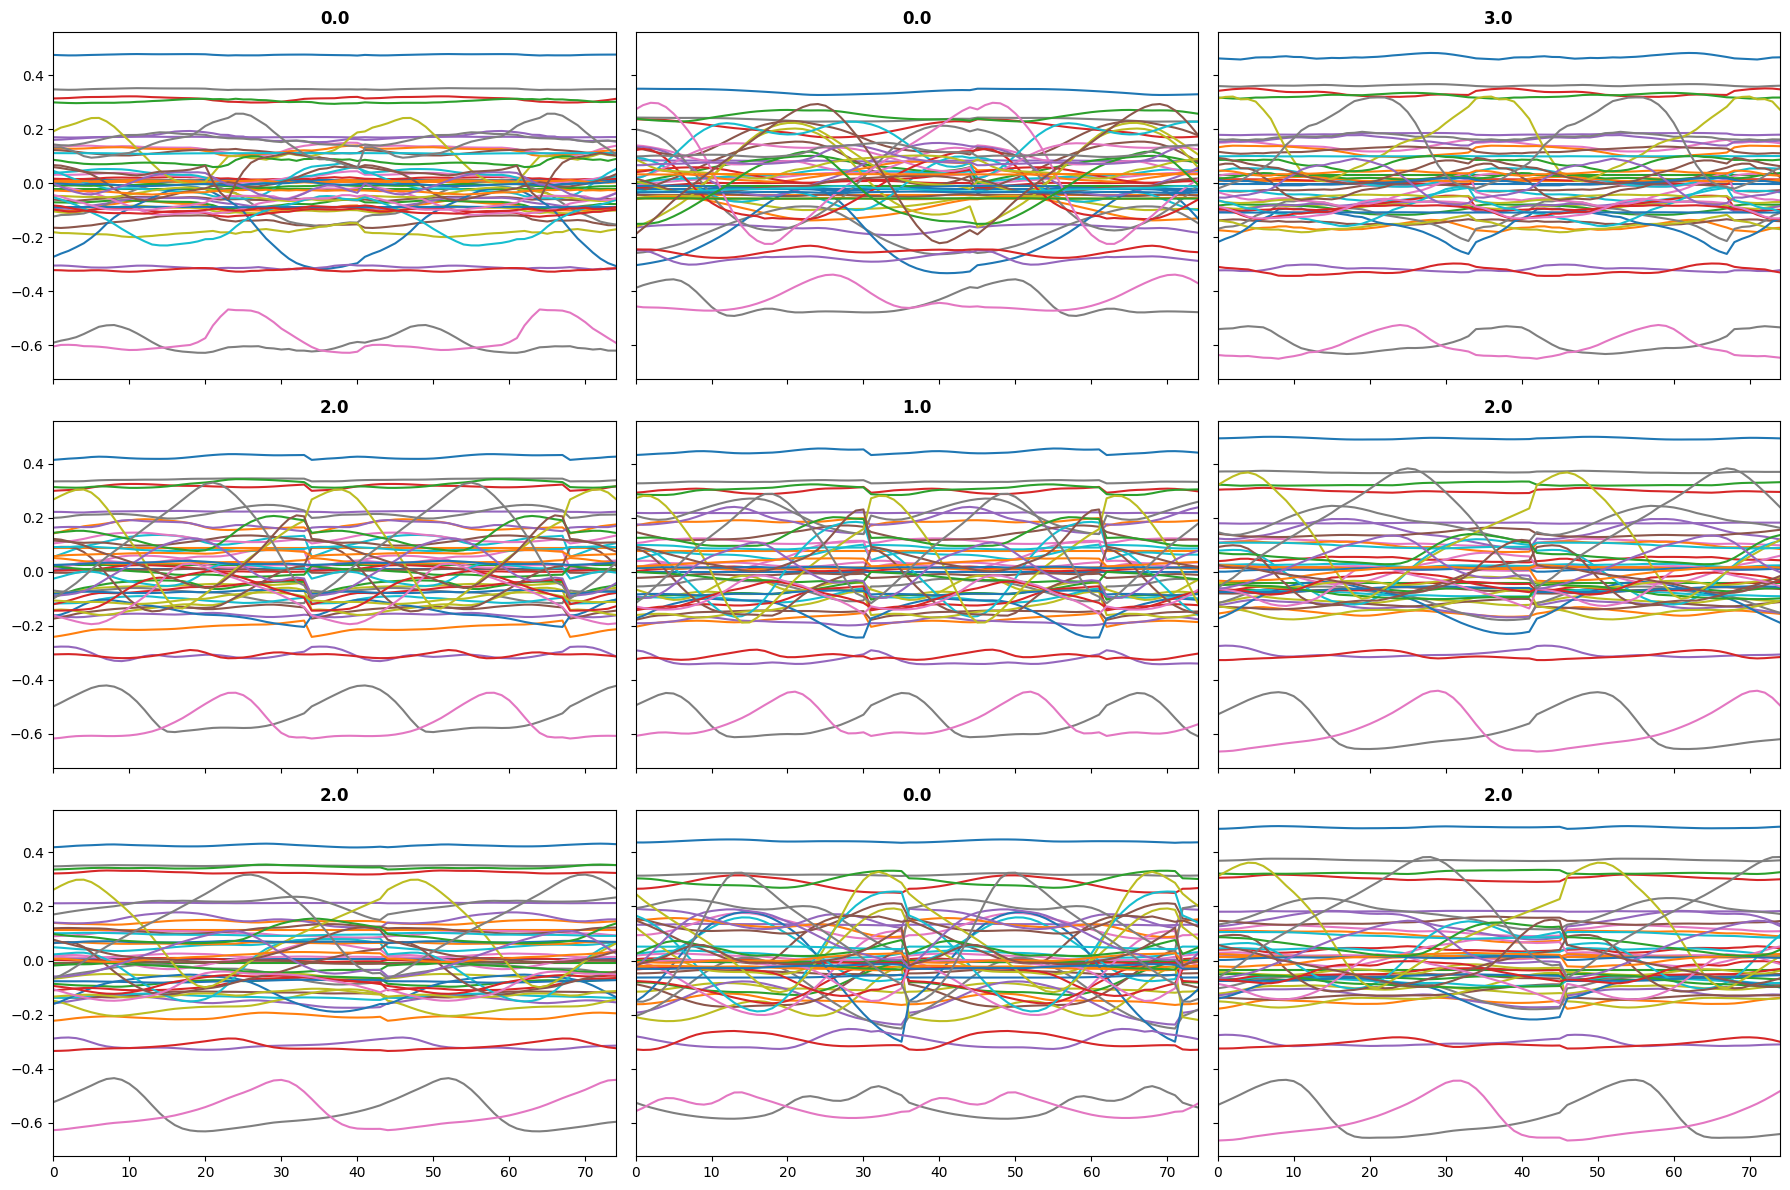

In [15]:
#### converting data into tsai format###########
X,y,splits = combine_split_data([data_train_new,data_test_new],[labels_train,labels_test])  ### Converting data into TSAI compataible format
bs = 64   ### need to understand what bs is?
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])   ### copied from tutorial comparing different architectures
dls.show_batch(sharey = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.381001,1.386674,0.342857,00:00
1,1.359183,1.379808,0.314286,00:00
2,1.329699,1.367776,0.228571,00:00
3,1.299467,1.356106,0.200000,00:00
4,1.261000,1.345235,0.257143,00:00
5,1.219925,1.324895,0.257143,00:00
6,1.179205,1.270282,0.342857,00:00
7,1.138751,1.135307,0.542857,00:00
8,1.093648,0.945933,0.714286,00:00
9,1.050593,0.837159,0.714286,00:00


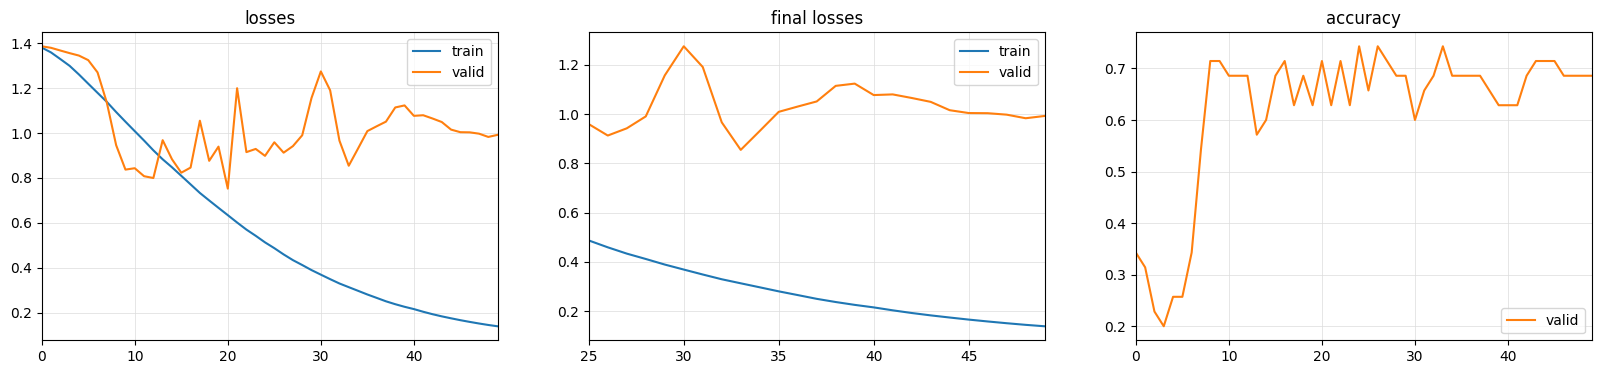


training time: 00:00:25


In [16]:
#### Training of the model############
model = create_model(FCN,dls=dls)
epochs = 50
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
start = time.time()
learn.fit_one_cycle(epochs, lr_max=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")

In [17]:
#### Validation of data#######
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)    ####From the intro to time series classification
valid_probas, valid_targets, valid_preds



(TensorBase([[5.6064e-03, 1.3081e-03, 5.4139e-01, 4.5169e-01],
             [3.1941e-03, 1.4964e-03, 1.8978e-02, 9.7633e-01],
             [6.2513e-01, 5.9047e-02, 4.5389e-02, 2.7043e-01],
             [8.9254e-01, 8.5674e-02, 1.9639e-02, 2.1436e-03],
             [7.5787e-01, 5.3421e-02, 1.6393e-02, 1.7231e-01],
             [6.2854e-04, 2.6669e-04, 2.2095e-02, 9.7701e-01],
             [9.4748e-01, 3.0924e-03, 2.8779e-02, 2.0653e-02],
             [9.8153e-01, 3.1514e-03, 1.4901e-03, 1.3825e-02],
             [1.6315e-02, 6.5522e-03, 2.4653e-01, 7.3061e-01],
             [2.3389e-02, 5.2647e-03, 8.0966e-04, 9.7054e-01],
             [7.9524e-01, 8.6901e-03, 3.7798e-03, 1.9229e-01],
             [7.9514e-01, 4.8615e-02, 1.9972e-02, 1.3627e-01],
             [2.6190e-01, 7.1639e-01, 8.2467e-03, 1.3466e-02],
             [7.0675e-01, 1.0798e-02, 2.0132e-02, 2.6232e-01],
             [2.1888e-03, 2.2147e-03, 3.0986e-03, 9.9250e-01],
             [1.8475e-05, 1.8270e-05, 9.9990e-01, 6.673

In [18]:
#### Outputting stuff######

(valid_targets == valid_preds).float().mean()



TensorBase(0.6857)

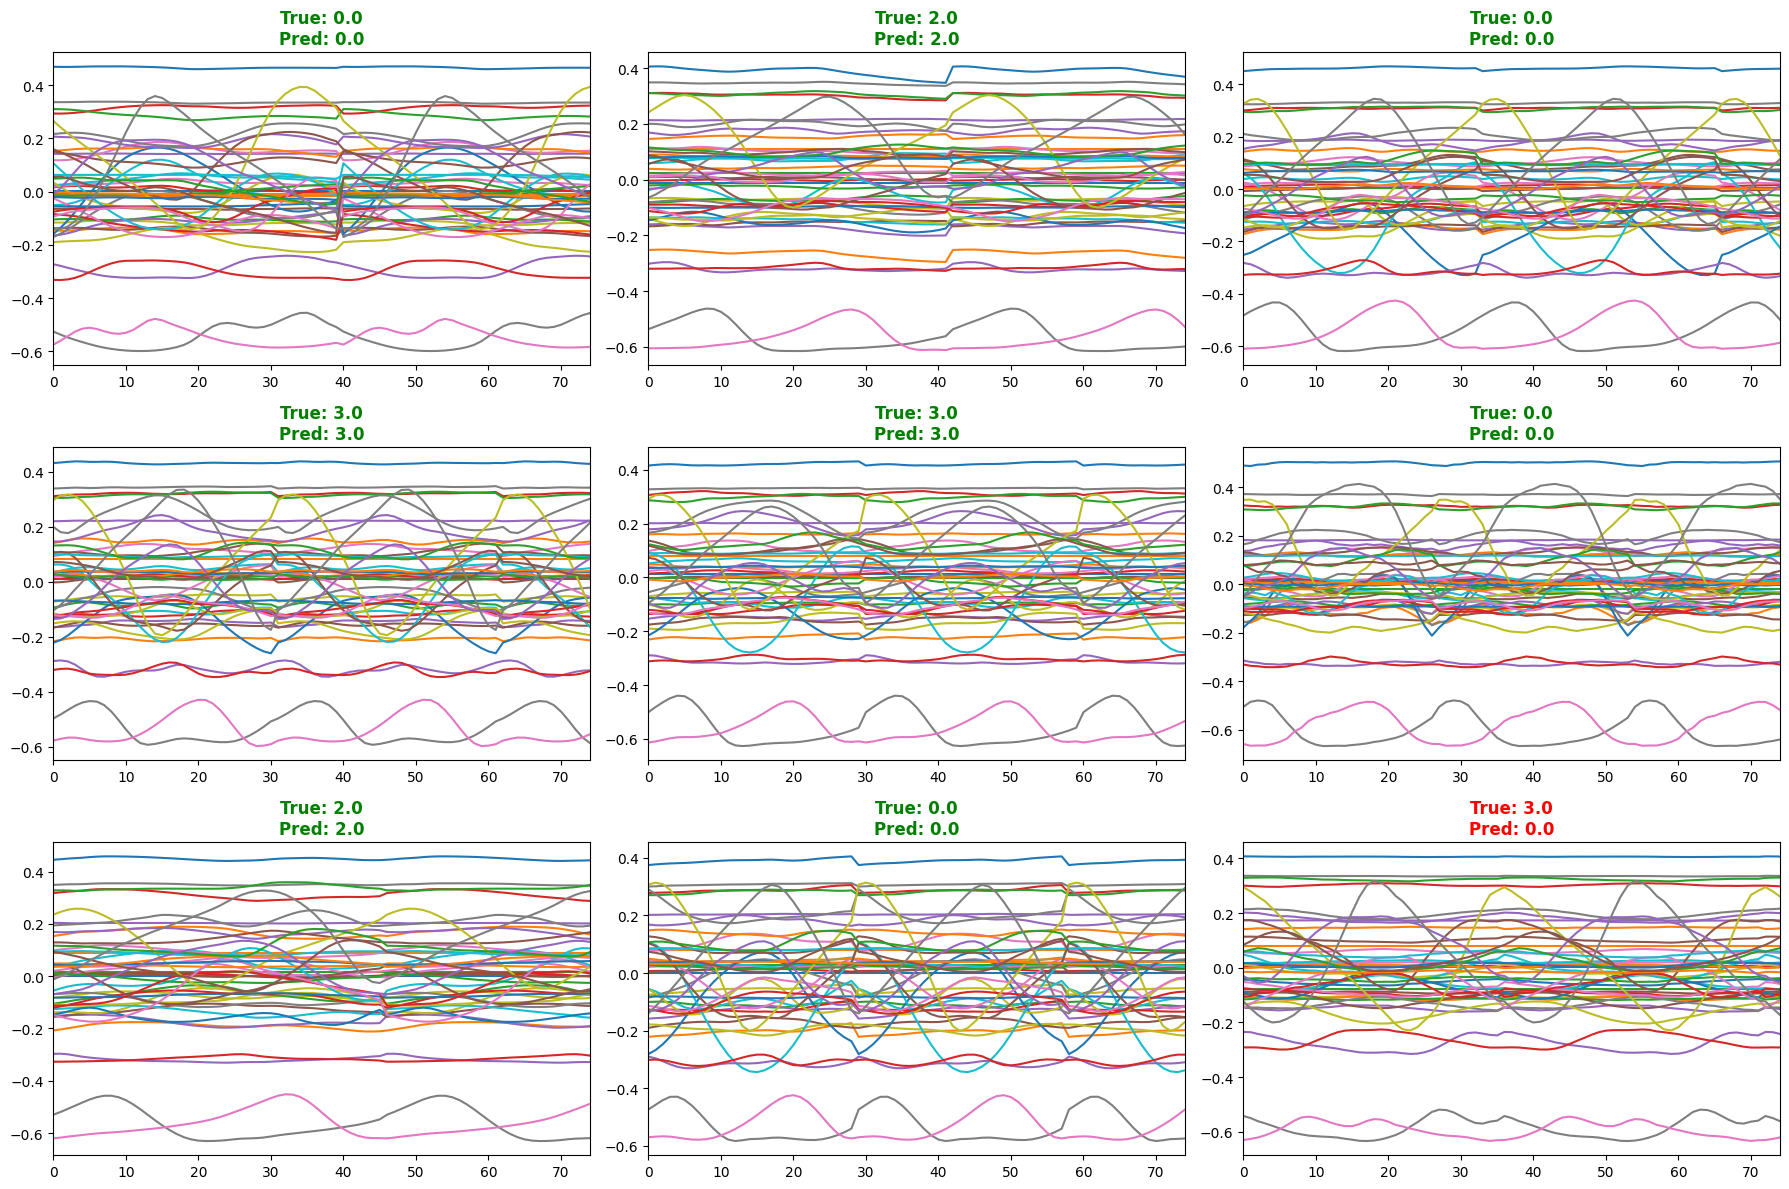

In [19]:
learn.show_results()





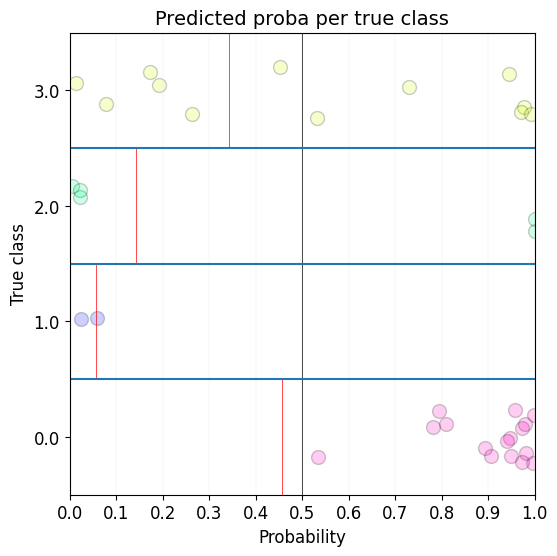

In [20]:
learn.show_probas()

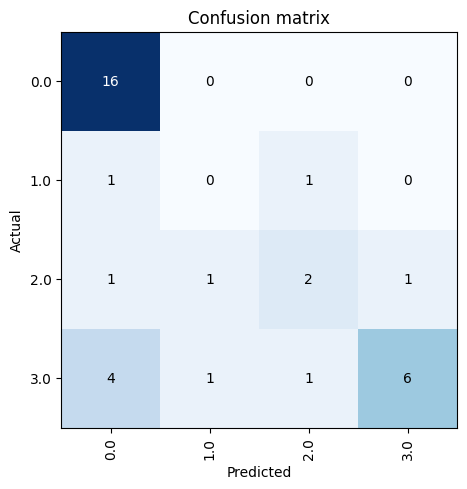

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
interp.most_confused(min_val=3)

[(3.0, 0.0, 4)]

In [23]:
#### onnx conversion######
dummy_input = torch.randn(1,48,75).cuda()
#dummy_input = np.zeros(data_train[1].shape)
name = "FCN_outputModel.onnx"

torch.onnx.export(model,dummy_input,name,export_params=True, opset_version=10,do_constant_folding=True,input_names = ['input'],output_names = ['output'])
